# Manejo de Datos Faltantes: Imputación

## Indice <a id='indice'></a>
0. [Configuración previa](#tema0)
1. [El problema de trabajar con valores faltantes](#tema1)
2. [Proceso de análisis y limpieza de datos](#tema2)
3. [Visualizar y eliminar valores faltantes](#tema3)
4. [Implicaciones de los distintos tipos de valores faltantes](#tema4)
5. [Amplia tu conjunto de herramientas para explorar valores faltantes](#tema5)
6. [Tratamiento de variables categóricas para imputación: codificación ordinal](#tema6)
7. [Tratamiento de variables categóricas para imputación: one-hot encoding](#tema7)
8. [Métodos de imputación de valores faltantes](#tema8)
9. [Imputación por media, mediana y moda](#tema9)
10. [Imputación por llenado hacia atrás y hacia adelante](#tema10)
11. [Imputación por interpolación](#tema11)
12. [Imputación por KNN](#tema12)
13. [Imputación por KNN en Python](#tema13)
14. [Introducción a la imputación basada en modelos](#tema14)
15. [Imputaciones Múltiples por Ecuaciones Encadenadas(MICE)](#tema15)
16. [Transformación inversa de los datos](#tema16)
17. [¿Cómo continuar practicando?](#tema17)


## Configuración de ambiente de trabajo <a id='tema0'></a>  

[Ir a indice](#indice)

Primero creemos un entorno con conda y después ejecutemos el archivo [requirements.txt](requirements.txt) para instalar las dependencias adecuadas.

```sh
#Crear un entorno llamado detección con python 3.9
conda create --name imputacion python=3.9
#Para que sea más rápido lo haré con mamba
mamba create --name imputacion python=3.9
#activar el entorno
conda activate imputacion
#instalar las dependencias desde requirements.txt
mamba install --file requirements.txt
#crear archivo requirements.txt si no lo tengo
mamba env export > requirements.txt
```

Si no podemos instalar con Conda, podemos usar este código:
```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

### Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/nhanes/load.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


### Importar funciones personalizadas

In [2]:
#Instala antes nbformat
%run pandas-missing-extension-re.ipynb

La función anterior proviene del curso anterior.

## El problema de trabajar con valores faltantes <a id='tema1'></a>

[Ir a indice](#indice)

Esto lo abarcamos en el anterior curso de Exploración y detección de valores faltantes.

Problemas que nos podemos encontrar:
1. Ignorar valores faltantes: Introduce **sesgos** en el análisis y modelos. De tal manera que *Sobreestimamos o Subestimamos* al valor real, provoca problemas serios al momento de reportar los resultados.
2. Multiples algoritmos fallarán: Los algoritmos que tenemos disponibles en la red, fallarán; es decir aparecerán errores y otros estarán dando resultados no deseados.

Nosotros hablamos anteriormente sobre la imputación, pero nunca la definimos.

### Imputación

Estimar los valores ausentes con base en los valores válidos de otras variables y/o casos de muestra.

A continuación vamos a proceder a empezar a trabajar:

In [3]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year",1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year","month","day"]])    
    )
    .sort_values(by='date')
    .set_index('date')
)
airquality_df

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.assign` instead.
  return method(self._obj, *args, **kwargs)


,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


En el código anterior lo que hicimos fue traer un data set de R, y añadimos una columna con formato de fecha.

Ademas el conjunto de datos lo usaremos en clases posteriores.

### ¿Cuál es el problema?
Imaginemos que ya tenemos los datos y queremos ajustarlos a un modelo, entonces procedemos a realizar lo siguiente:

In [4]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Thu, 21 Nov 2024",Prob (F-statistic):,2.93e-18
Time:,23:48:21,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


De momento ya tenemos las variables dependientes y el modelo que utilizamos, es decir parece que está bien.

Pero recordemos que algunas variables tienen valores faltantes.

¿Qué pasaría si yo quiero considerar otra variable?

*solar_r*

In [5]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Thu, 21 Nov 2024",Prob (F-statistic):,1.47e-16
Time:,23:48:21,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


Todo bien al parecer, no nos da ningún error.

**Pero ese es el problema precisamente de los valores faltantes; es decir no nos arrojan errores**

Pero si existe.

Veamos el número de observaciones en nuestro modelo;
 - Modelo: 116 observaciones
 - Data Frame: 153 observaciones

Entonces cuando creamos el primer modelo **tenemos 116 observaciones**. Y si creamos el segundo, vemos que disminuye a **111 observaciones.**

Es decir también perdimos más filas, y a pesar que queramos comparar los modelos, como normalmente lo haríamos con el $R^2$ no podríamos hacerlo, porque ambos modelos están siendo ajustados a partir de diferentes conjuntos de datos y eso hace que se pierda información. Debido a que los algoritmos descartan ciertos valores, así que cuando nosotros tenemos valores faltantes no es recomendable hacer esto.

Esto es un problema porque puede parecer que es adecuado, ya que no nos arroja ningún *Warning* o *Error*- Por ello, siempre hay que estar atento.

Por eso, en este curso nos enfocaremos en la imputación de valores faltantes:

### Reto: Datos de supervivientes

In [6]:
survival_df = sm.datasets.get_rdataset("flchain","survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [7]:
survival_df.columns

Index(['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine',
       'mgus', 'futime', 'death', 'chapter'],
      dtype='object')

In [8]:
(
    smf.ols(
        formula="death ~ chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-143.5
Date:,"Thu, 21 Nov 2024",Prob (F-statistic):,1.00
Time:,23:48:22,Log-Likelihood:,71215.
No. Observations:,2169,AIC:,-1.424e+05
Df Residuals:,2153,BIC:,-1.423e+05
Df Model:,15,,
Covariance Type:,nonrobust,,


In [9]:
(
    smf.ols(
        formula="death ~ age + chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-134.5
Date:,"Thu, 21 Nov 2024",Prob (F-statistic):,1.00
Time:,23:48:22,Log-Likelihood:,69860.
No. Observations:,2169,AIC:,-1.397e+05
Df Residuals:,2152,BIC:,-1.396e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


## Proceso de análisis y limpieza de datos <a id='tema2'></a>

[Ir a Indice](#indice)

En este curso conoceremos, exploraremos y limpiaremos nuestro set de datos antes de imputarlos.

En este caso examinaremos NHANES.

### Preparando datos: _National Health and Nutrition Examination Survey_

In [10]:
(
    nhanes.load.load_NHANES_data(year="2017-2018")
)

,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,TypeOfMilkFirstFed1Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


Como se puede observar tenemos un total de:
- 8366 filas 
- 197 columnas

También podemos ver que podemos cambiar el encabezado de las columnas a un tipo diferente

In [11]:
(
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(
        case_type='snake'
    )
)

,general_health_condition,ever_breastfed_or_fed_breastmilk,age_stopped_breastfeedingdays,age_first_fed_formuladays,age_stopped_receiving_formuladays,age_started_other_foodbeverage,age_first_fed_milkdays,type_of_milk_first_fed_whole_milk,type_of_milk_first_fed2_milk,type_of_milk_first_fed1_milk,...,days_smoked_cigs_during_past30_days,avg_cigarettesday_during_past30_days,tried_to_quit_smoking,times_stopped_smoking_cigarettes,how_long_were_you_able_to_stop_smoking,unit_of_measure_dayweekmonthyear_2_smq,current_selfreported_height_inches,current_selfreported_weight_pounds,tried_to_lose_weight_in_past_year,times_lost10_lbs_or_more_to_lose_weight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


Ahora hemos separado las palabras con un "_", por lo que nos facilita la lectura.

Ya que tenemos esto, necesariamente tenemos que guardarlo en un conjunto de datos, para después usarlo.

In [12]:
nhanes_raw_df = (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(
        case_type='snake'
    )
)
nhanes_raw_df.shape

(8366, 197)

### Procesar el Data Frame

In [13]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )

)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,age_in_years_at_screening,gender,current_selfreported_height_inches,current_selfreported_weight_pounds,doctor_told_you_have_diabetes,60_sec_pulse30_sec_pulse2,total_cholesterol_mgdl
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,NaN,117.0,Borderline,68.0,119.0
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


Una vez que hemos seleccionado las columnas, lo que necesitamos hacer ahora es renombrar las columnas, porque son nombres demasiado largos y difícil de recordar.

In [14]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,age,gender,height,weight,diabetes,pulse,cholesterol_mgdl
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,NaN,117.0,Borderline,68.0,119.0
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


### Codificando valores faltantes

In [15]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,age,gender,height,weight,diabetes,pulse,cholesterol_mgdl
SEQN,,,,,,,,
93703.0,NaN,2.0,Female,NaN,NaN,0,NaN,NaN
93704.0,NaN,2.0,Male,NaN,NaN,0,NaN,NaN
93705.0,Good,66.0,Female,63.0,165.0,0,52.0,157.0
93706.0,Very good,18.0,Male,68.0,145.0,0,82.0,148.0
93707.0,Good,13.0,Male,NaN,NaN,0,100.0,189.0
...,...,...,...,...,...,...,...,...
102952.0,Very good,70.0,Female,NaN,117.0,NaN,68.0,119.0
102953.0,Fair or,42.0,Male,65.0,218.0,0,78.0,182.0
102954.0,Good,41.0,Female,66.0,150.0,0,78.0,172.0


### Ordenamiento

In [16]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102952.0,NaN,117.0,Very good,119.0,68.0,NaN,70.0,Female
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Ahora ordenamos nuestro data frame con respecto de las variables que tienen mayor numero de valores faltantes, lo que se traduce al siguiente orden:
- height
- weight
- general_health_condition
- cholesterol_mgdl
- pulse
- diabetes
- age
- gender

### Eliminando valores nulos en "diabetes"

In [17]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how='any'   
        #Eliminación en cualquier valor nulo de diabetes
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


### Transformación de tipo (columnas)

In [18]:
#Seleccionando un sub_conjunto de columnas
(
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how='any'   
        #Eliminación en cualquier valor nulo de diabetes
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s:s.astype(int),
        #Para que nos regrese una serie y no un
        #elemento
        elementwise = False    
    )
)

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


LISTO YA PODRÍAMOS EMPEZAR A TRABAJARLO.

Primero guardemoslo en un conjunto de datos.

In [19]:
#Seleccionando un sub_conjunto de columnas
nhanes_df = (
    nhanes_raw_df
    .select_columns(
        'general_health_condition',
        'age_in_years_at_screening',
        'gender',
        'current_selfreported_height_inches',
        'current_selfreported_weight_pounds',
        'doctor_told_you_have_diabetes',
        '60_sec_pulse30_sec_pulse2',
        'total_cholesterol_mgdl'
    )
    .rename_columns(
        {
            'age_in_years_at_screening':"age",
            'current_selfreported_height_inches':"height",
            'current_selfreported_weight_pounds':"weight",
            'doctor_told_you_have_diabetes':"diabetes",
            '60_sec_pulse30_sec_pulse2':"pulse",
            'total_cholesterol_mgdl':"cholesterol_mgdl"
        }
    )
    .replace(
        {
            'height':{
                9999:np.nan,
                7777:np.nan
            },
            'weight':{
                9999:np.nan,
                7777:np.nan
            },
            'diabetes':{
                'Borderline':np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset=["diabetes"],
        how='any'   
        #Eliminación en cualquier valor nulo de diabetes
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s:s.astype(int),
        #Para que nos regrese una serie y no un
        #elemento
        elementwise = False    
    )
)
nhanes_df

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Con esto terminamos la clase y el procesamiento de datos desde 0, para tener un conjunto de datos y explorar sus valores faltantes.

Resumen:

- En esta clase realizamos todo el procesamiento de datos para tener un conjunto y así explorar e imputar los valores faltantes.

- Cambiamos los nombres de las columnas para que fuera más sencillo recordarlos y utilizarlos.

- Cambiamos la codificación de valores faltantes a un formato adecuado; es decir los representamos como lo que en verdad son: VALORES FALTANTES.

- Ordenamos el conjunto de datos de tal manera que nos pudiera decir que variables poseen mayor cantidad de valores faltantes.

- Eliminamos observaciones del Data Set para una columna en la cual no había tantos valores  faltantes, es decir su proporción de valores faltantes era muy baja.

- Finalmente transformamos una columna que tenía un tipo inadecuado para su contenido (tipo objeto), pero sabíamos que esta columna era de tipo numérico.


En resumen todo este procesamiento nos ayudará a que tengamos la información en una forma adecuada.

## Visualizar y eliminar valores faltantes <a id='tema3'></a>

[Ir a Indice](#indice)

Primero necesitamos verificar nuestro conjunto de datos **nhanes_df**

In [21]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
)

,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Female
93704.0,NaN,NaN,NaN,NaN,NaN,0,2.0,Male
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,4.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Ya tenemos la forma en que ordenamos por datos faltantes, pero podemos usar otra extension del paquete *missigno*

<Axes: >

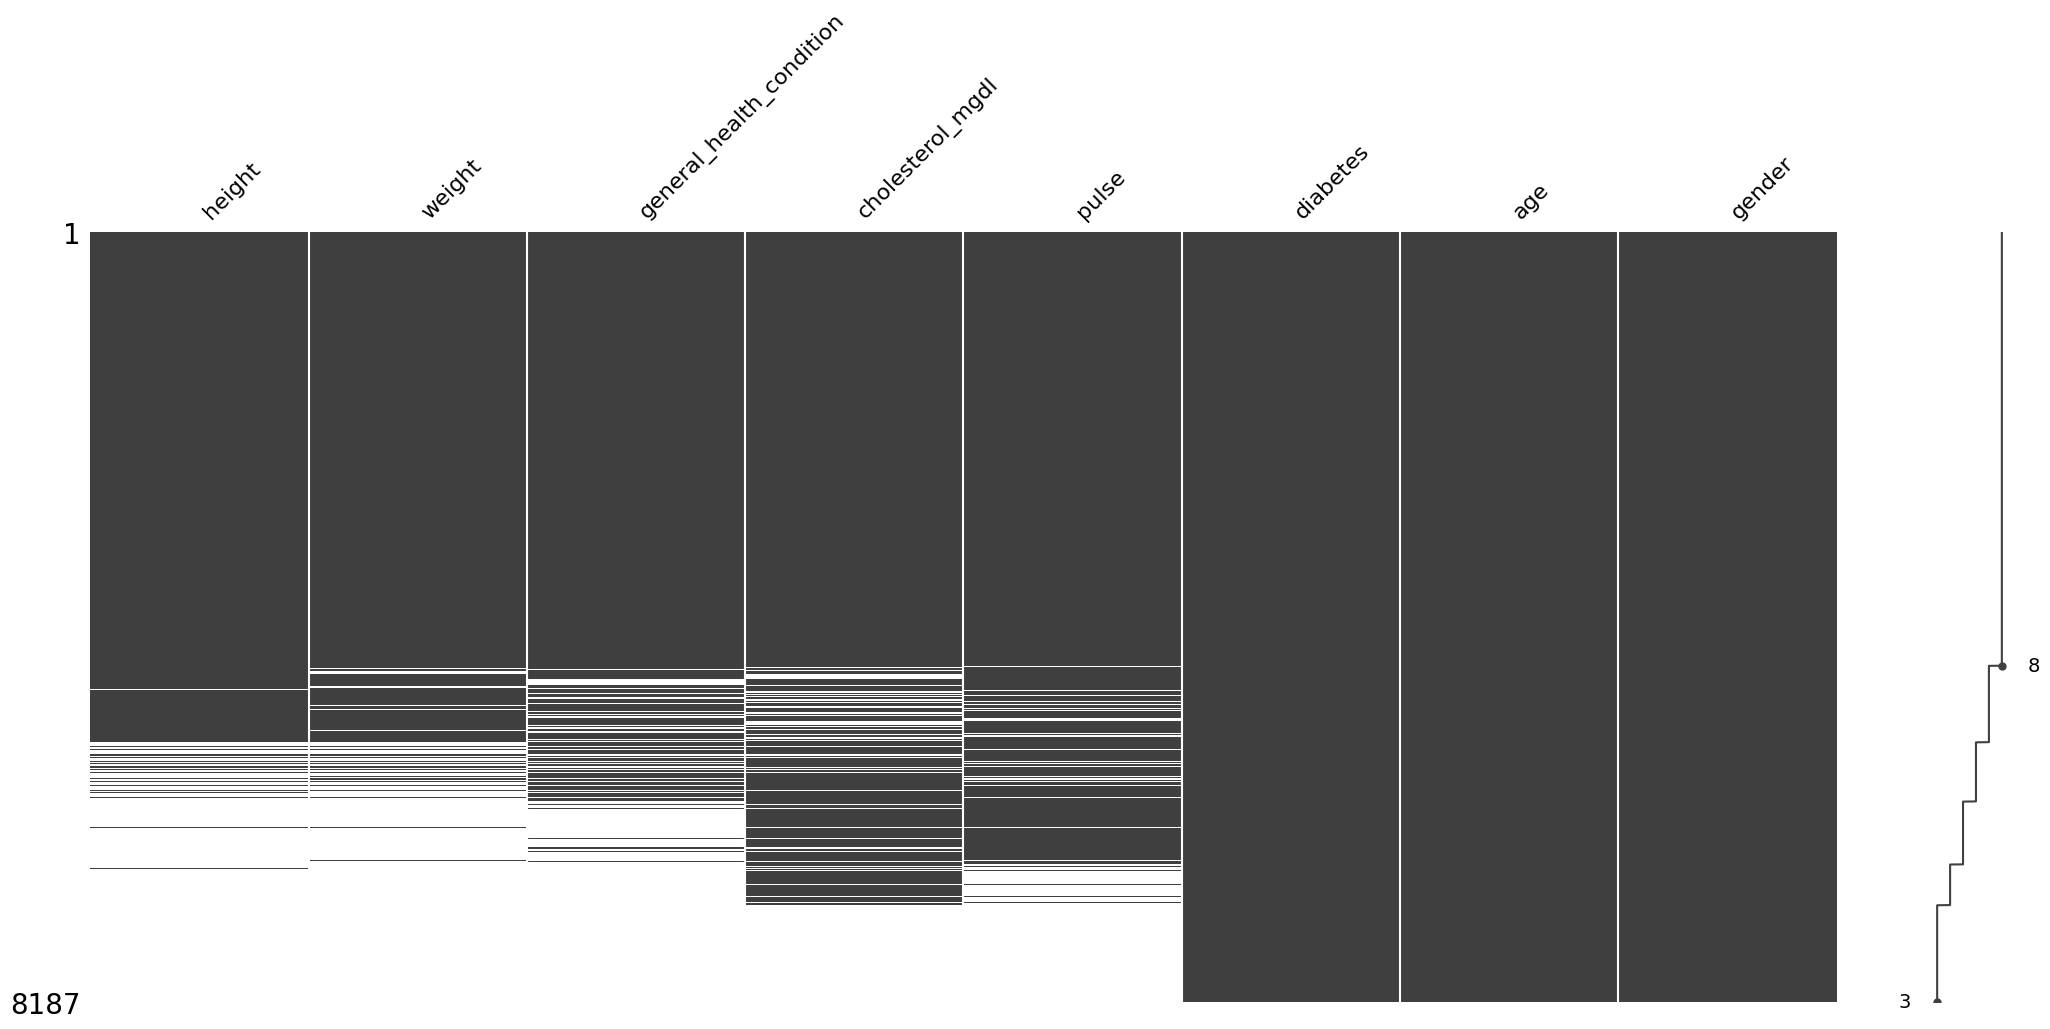

In [22]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix,sort='descending')
)

Aquí graficamos nuestro conjunto de datos por valores faltantes pero de forma descendente.

Vemos que hay 3 variables que no tienen valores faltantes y otras 5 que si tienen valores faltantes.

Veamos el comportamiento que tienen los valores faltantes en la parte inferior, donde hay una relación de valores faltantes en diversas variables.

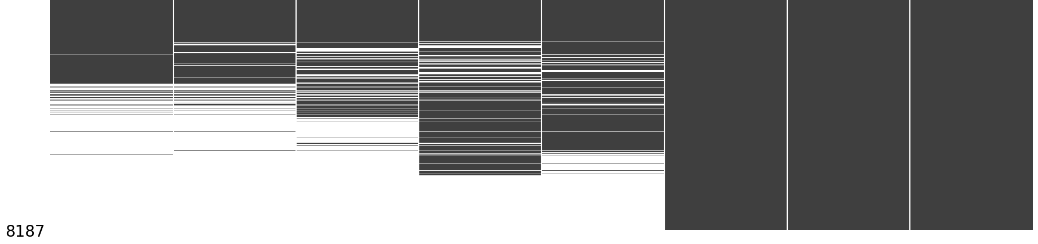

### ¿Cómo podemos visualizar la relación de  valores faltantes entre mis variables?

Usando un Upsetplot

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

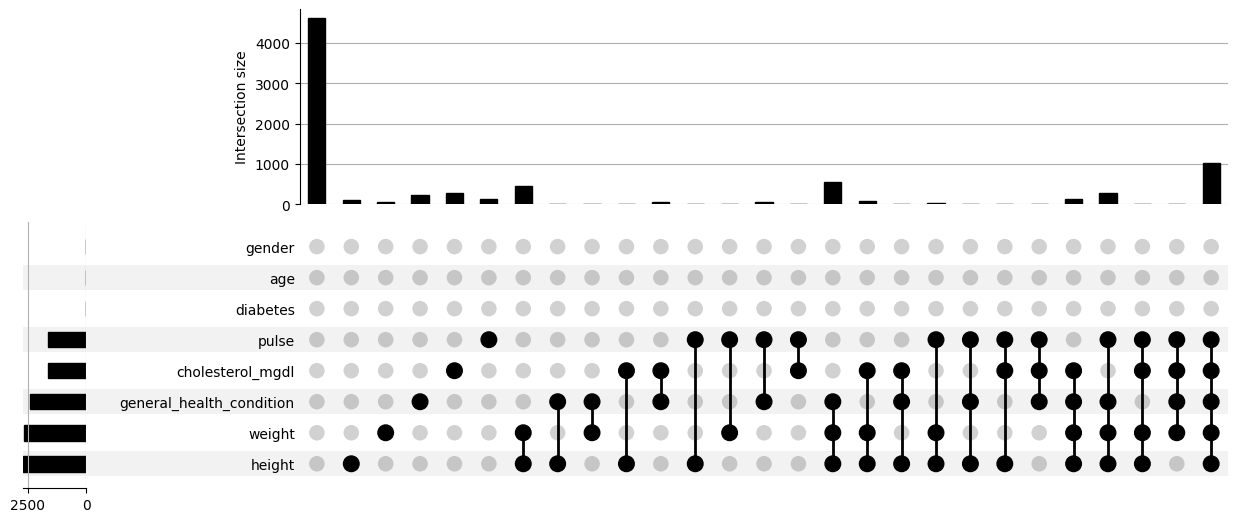

In [24]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

En la primera columna vemos que no hay valores faltantes y corresponden a nuestra mayor cantidad del set de datos. El resto de valores faltantes esta distribuido en las demás categorías o columnas.

Debemos poner atención en la última columna, es la que posee cerca de 1000 observaciones de valores faltantes, ademas se puede observar como es la relación con todas las variables que en este caso son 5.

Nosotros podemos elegir: eliminar o imputar, pero vamos a decantarnos por la imputación, que es lo que aprenderemos.


### Eliminando para fines prácticos

In [28]:
nhanes_df.columns

Index(['height', 'weight', 'general_health_condition', 'cholesterol_mgdl',
       'pulse', 'diabetes', 'age', 'gender'],
      dtype='object')

<Axes: >

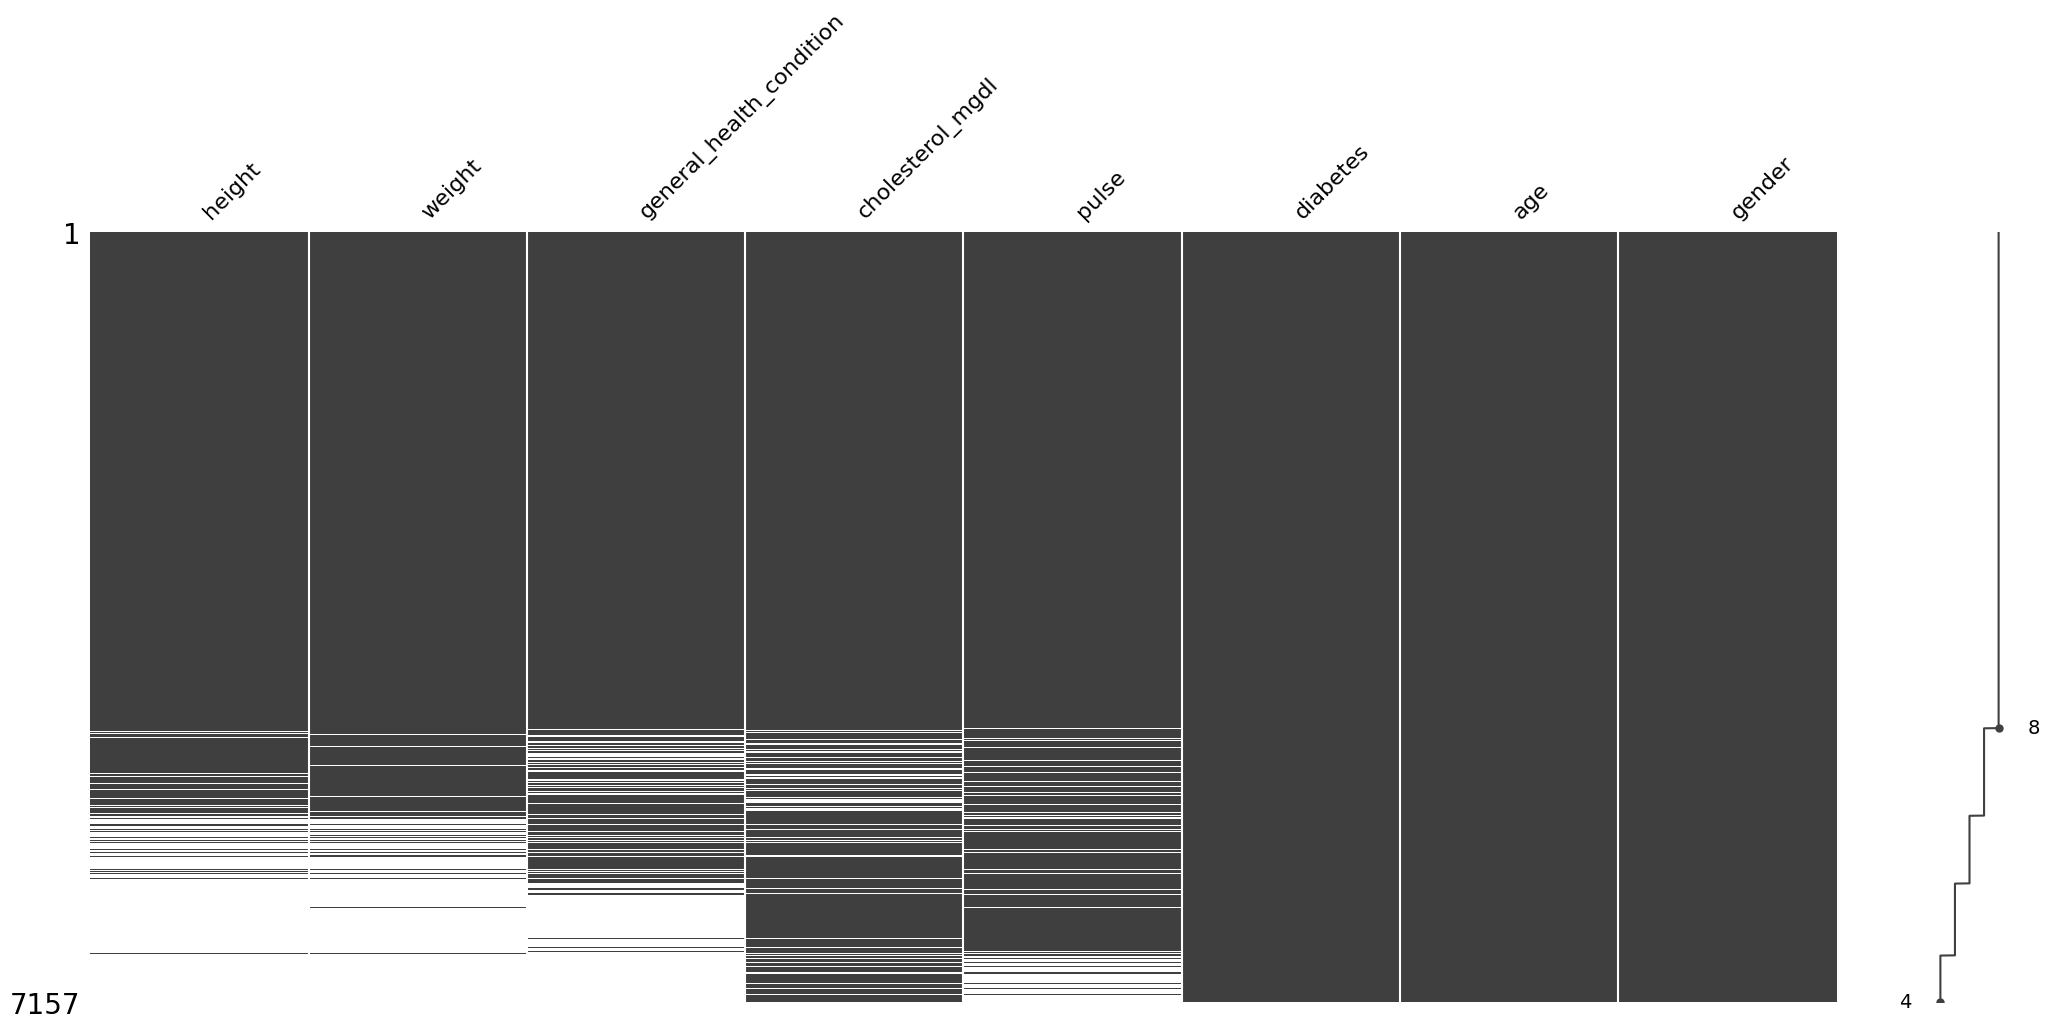

In [30]:
(
    nhanes_df
    .dropna(
        subset=['pulse','cholesterol_mgdl','general_health_condition','height','weight'],
        #Elimina faltantes solo si están en todas
        #las columnas
        how='all'
    )
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix,sort='descending')
)

Listo hemos conseguido eliminar la sección blanca de hasta abajo.

/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/dens/miniforge3/envs/imputacion/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

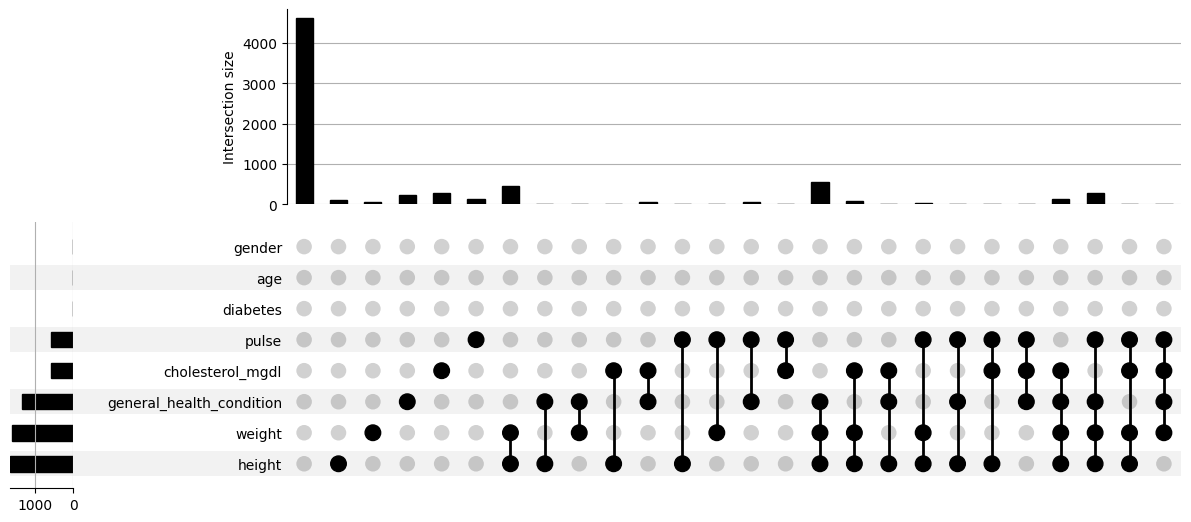

In [31]:
(
    nhanes_df
    .dropna(
        subset=['pulse','cholesterol_mgdl','general_health_condition','height','weight'],
        #Elimina faltantes solo si están en todas
        #las columnas
        how='all'
    )
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

Hemos conseguido eliminarla, como hemos constatado.

Pero vamos a guardarla en un nuevo data frame. Así que solo quitaremos la parte de la visualización en nuestro código.

In [33]:
nhanes_dfwo100=(
    nhanes_df
    .dropna(
        subset=['pulse','cholesterol_mgdl','general_health_condition','height','weight'],
        #Elimina faltantes solo si están en todas
        #las columnas
        how='all'
    )
    .missing.sort_variables_by_missingness()
)
nhanes_dfwo100

,height,weight,general_health_condition,cholesterol_mgdl,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


Hacemos la comparación de que tantas observaciones perdimos, recordemos que el numero de observaciones:

- nhanes_df tiene 8187
- nhanes_dfwo100 tiene 7157

### Ahora estamos listos para empezar a trabajar tomando como base nuestro set de datos con valores eliminados


## Implicaciones de los distintos tipos de valores faltantes <a id='tema4'></a>

[Ir a Indice](#indice)


## Amplia tu conjunto de herramientas para explorar valores faltantes <a id='tema5'></a>

[Ir a Indice](#indice)

## Tratamiento de variables categóricas para imputación: codificación ordinal <a id='tema6'></a>

[Ir a Indice](#indice)

## Tratamiento de variables categóricas para imputación: one-hot encoding <a id='tema7'></a>

[Ir a Indice](#indice)

## Métodos de imputación de valores faltantes <a id='tema8'></a>

[Ir a Indice](#indice)

## Imputación por media, mediana y moda <a id='tema9'></a>

[Ir a Indice](#indice)

## Imputación por llenado hacia atrás y hacia adelante <a id='tema10'></a>

[Ir a Indice](#indice)

## Imputación por interpolación <a id='tema11'></a>

[Ir a Indice](#indice)

## Imputación por KNN <a id='tema12'></a>

[Ir a Indice](#indice)

## Imputación por KNN en Python <a id='tema13'></a>

[Ir a Indice](#indice)

## Introducción a la imputación basada en modelos <a id='tema14'></a>

[Ir a Indice](#indice)

## Imputaciones Múltiples por Ecuaciones Encadenadas(MICE) <a id='tema15'></a>

[Ir a Indice](#indice)

## Transformación inversa de los datos <a id='tema16'></a>

[Ir a Indice](#indice)

## ¿Cómo continuar practicando? <a id='tema17'></a>

[Ir a Indice](#indice)